# KNN 연구과제


## 문제 2

아래의 데이터는 사과의 크기, 무게, 단맛, 바삭함, 과즙, 숙성도, 신맛, 품질과 같은 세부 정보를 통해 사과의 품질을 좋음(`good`)과 나쁨(`bad`)로 구분하고 있다.

이 데이터 셋을 활용하여 사과를 상품과 하품으로 분류하기 위한 모형을 로지스틱과 KNN으로 구현하고 더 좋은 성능을 보이는 분류 모형과 성능 평가 지표를 제시하시오.

> https://data.hossam.kr/mldata/apple_quality.xlsx

> https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

| 변수 | 설명 |
|---|---|
| A_id | 각 과일의 고유 식별자 |
| Size | 과일의 크기 |
| Weight | 과일의 무게 |
| Sweetness | 과일의 단맛 정도 |
| Crunchiness | 과일의 아삭함을 나타내는 질감 |
| Juiciness | 과일의 과즙이 풍부한 정도 |
| Ripeness | 과일이 익는 단계 |
| Acidity | 과일의 산도 정도 |
| Quality | 과일의 전반적인 품질 (`good`, `bad`) |


> 전처리 아이디어
[가설]
1. Size가 클수록 좋은 사과
2. 무게가 클수록 좋은 사과 -> size대비 무게가 클 수록 더 좋지 않을까?
3. 당도가 높을 수록 좋은사과
4. Crunchiness
   - Like color, firmness changes as fruits ripen to become softer. Horticulturists and consumers have traditionally used firmness as a sensory quality parameter to measure texture.
5. 과즙이 많을 수록 좋은 사과
6. '적당히'익을수록 좋은 사과
7. 산도가 낮을수록 좋은 사과?
   - A Brix/acid ratio is used to determine flavor and taste to ensure the correct balance of the two quality parameters.
   - Acidity has the highest heritability among all the factors that influence the quality, making it a significant subject of crop research targeting fruit quality.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

### [1] 데이터 가져오기

In [2]:
origin = my_read_excel('https://data.hossam.kr/mldata/apple_quality.xlsx', index_col='A_id')
my_pretty_table(origin.head())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4001 entries, 0.0 to nan
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4001 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 281.3+ KB
None

데이터프레임 상위 5개 행
+--------+-----------+----------+-------------+---------------+-------------+------------+-----------+-----------+
|   A_id |      Size |   Weight |   Sweetness |   Crunchiness |   Juiciness |   Ripeness |   Acidity | Quality   |
|--------+-----------+----------+-------------+---------------+-------------+------------+-----------+-----------|
|      0 |  -3.97005 | -2.51234 |     5.34633 |    

In [24]:
df= origin.copy()
df.dropna(axis=0, inplace=True)

### [2] 데이터 시각화

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4000 entries, 0.0 to 3999.0
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 281.2+ KB


In [25]:
df['Acidity'] = df['Acidity'].astype('float64')

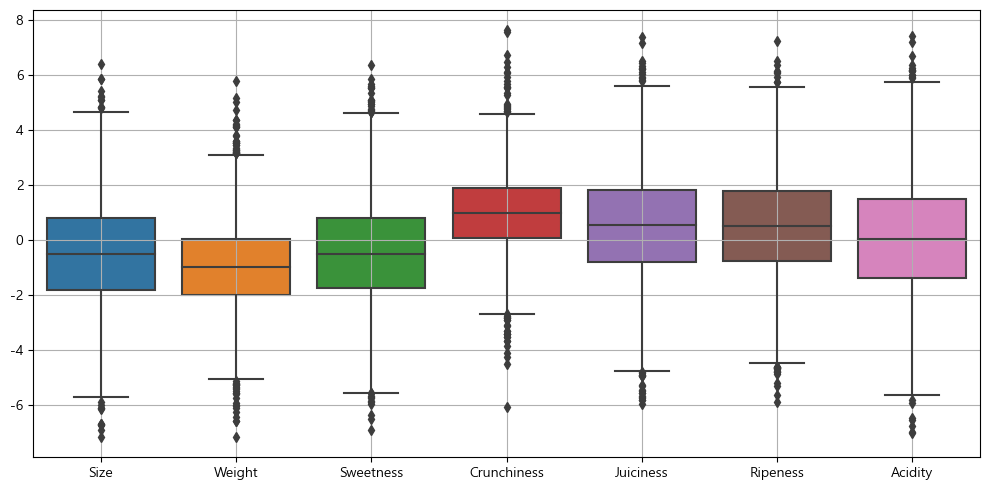

In [26]:
my_boxplot(df)

In [13]:
# 의미가 없었음. 과대적합 심화
df['density'] = df['Weight']/df['Size']
df.drop(['Size', 'Weight'], axis=1, inplace=True)
df

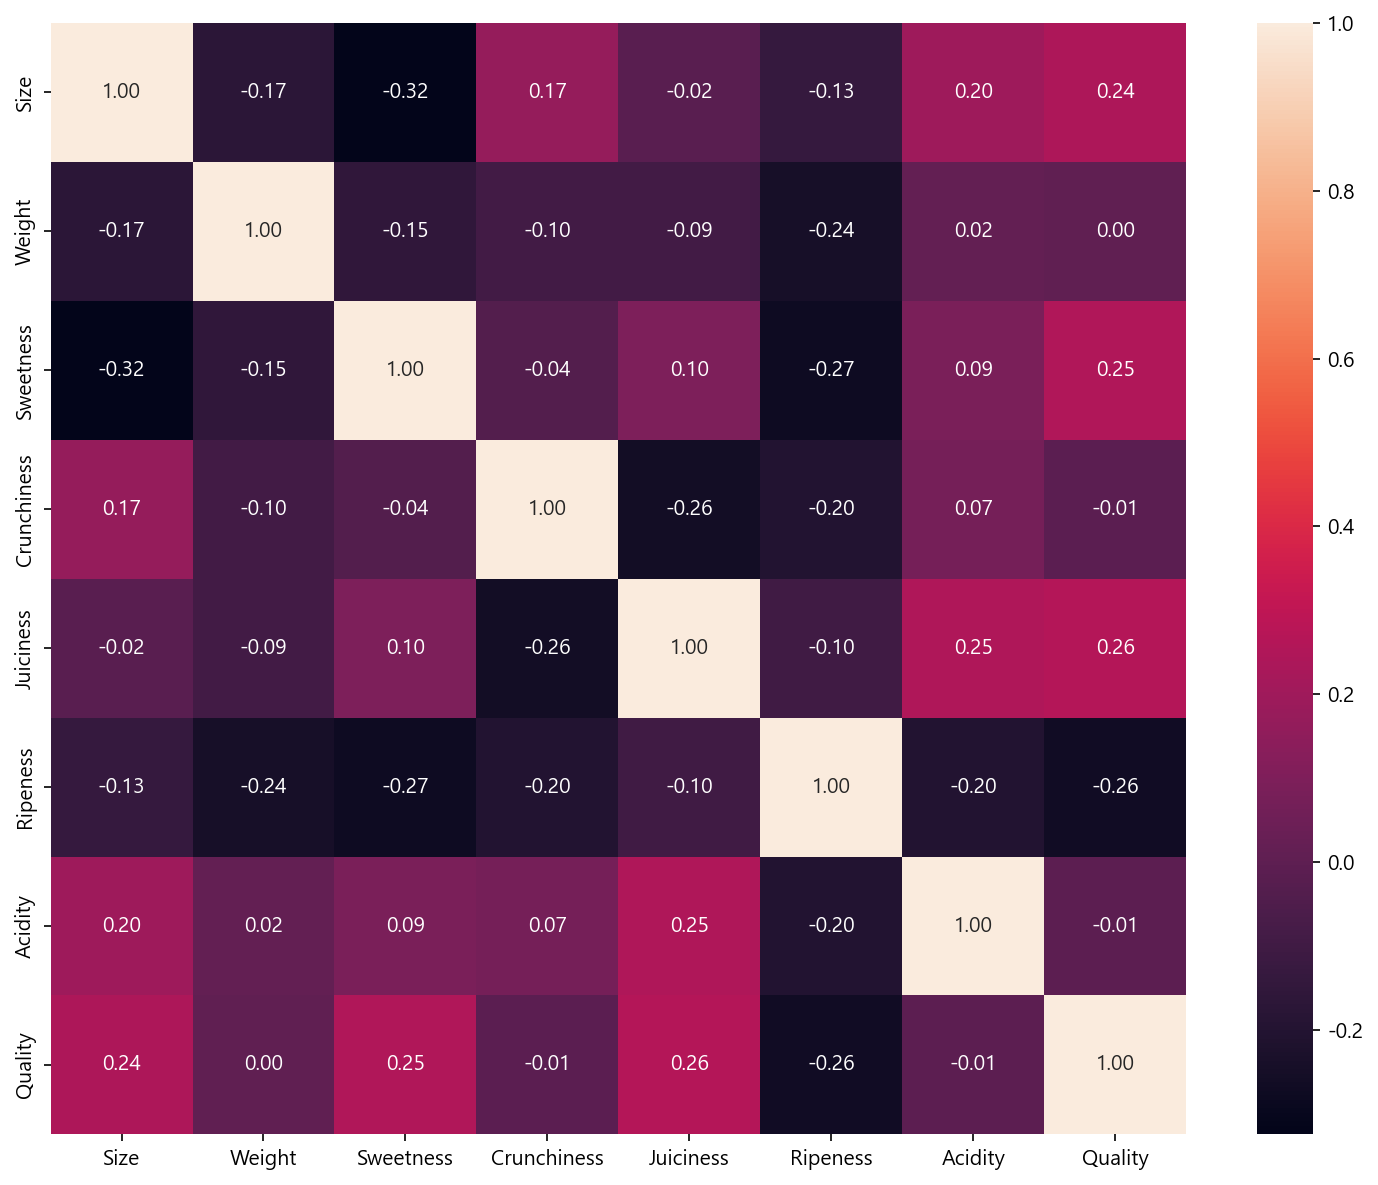

+------------------------------+---------------+-------------+----------+
|                              |   correlation |     p-value | result   |
|------------------------------+---------------+-------------+----------|
| ('Size', 'Weight')           |     -0.170702 | 1.55637e-27 | True     |
| ('Size', 'Sweetness')        |      -0.32468 | 7.55133e-99 | True     |
| ('Size', 'Crunchiness')      |      0.169868 | 2.80558e-27 | True     |
| ('Size', 'Juiciness')        |    -0.0188924 |    0.232245 | False    |
| ('Size', 'Ripeness')         |     -0.134773 | 1.12667e-17 | True     |
| ('Size', 'Acidity')          |      0.196218 | 5.24603e-36 | True     |
| ('Size', 'Quality')          |      0.244007 | 2.62825e-55 | True     |
| ('Weight', 'Size')           |     -0.170702 | 1.55637e-27 | True     |
| ('Weight', 'Sweetness')      |     -0.154246 |  1.0085e-22 | True     |
| ('Weight', 'Crunchiness')    |    -0.0958817 | 1.23063e-09 | True     |
| ('Weight', 'Juiciness')      |    -0

In [28]:
my_correlation(df1)

### [2] 데이터 전처리

1. 종속변수 라벨링
3. 훈련/검증 데이터 분리 + 데이터 스케일링

In [27]:
df1 = my_labelling(df, 'Quality')

x_train, x_test, y_train, y_test = my_train_test_split(df1, yname = 'Quality', test_size=0.2, scalling=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3200, 7), (800, 7), (3200,), (800,))

### [3] KNN 분류 구현

[교차검증]
+----+-----------+---------------+-----------+-------------------+
|    | metric    |   n_neighbors | weights   |   mean_test_score |
|----+-----------+---------------+-----------+-------------------|
|  5 | euclidean |             7 | distance  |          0.805625 |
|  4 | euclidean |             7 | uniform   |           0.80375 |
| 11 | manhattan |             7 | distance  |           0.80375 |
|  3 | euclidean |             5 | distance  |          0.801875 |
| 10 | manhattan |             7 | uniform   |          0.801562 |
|  0 | euclidean |             3 | uniform   |          0.798438 |
|  1 | euclidean |             3 | distance  |          0.797813 |
|  2 | euclidean |             5 | uniform   |          0.797813 |
|  9 | manhattan |             5 | distance  |           0.79625 |
|  8 | manhattan |             5 | uniform   |             0.795 |
|  6 | manhattan |             3 | uniform   |            0.7925 |
|  7 | manhattan |             3 | distance  |         

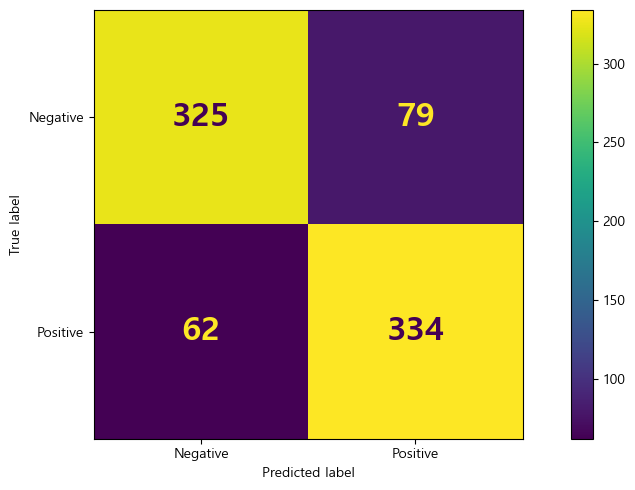


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


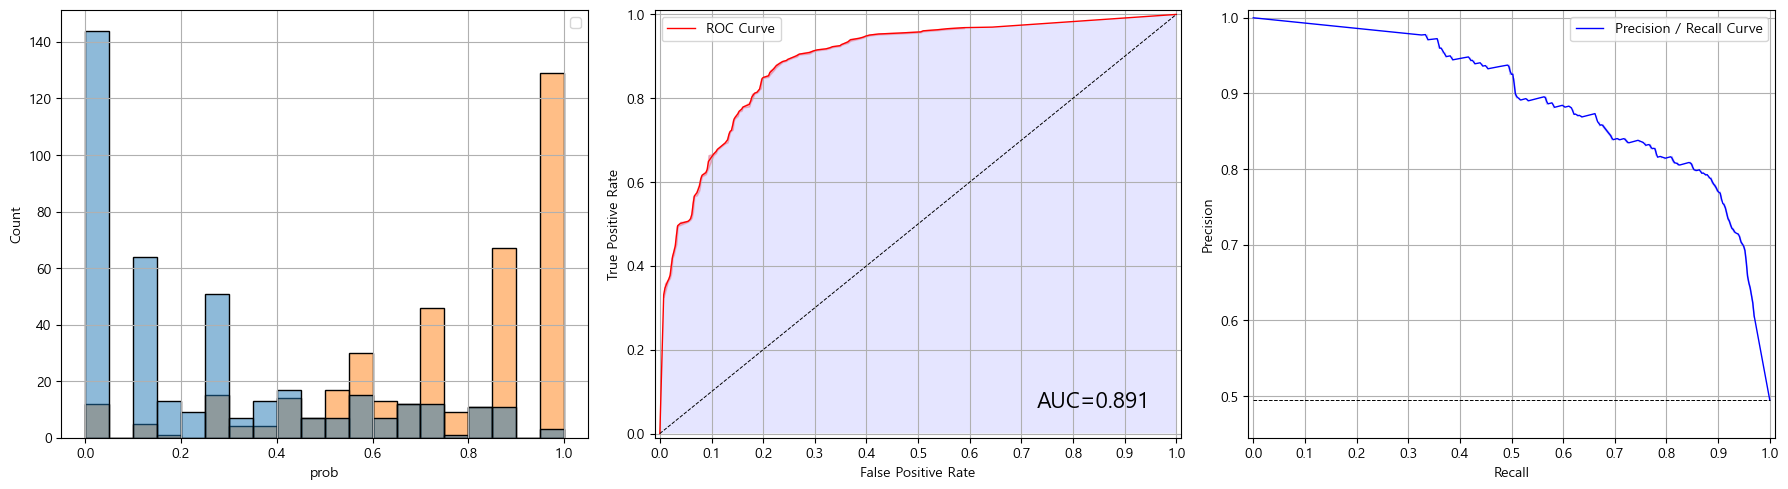


[학습곡선]


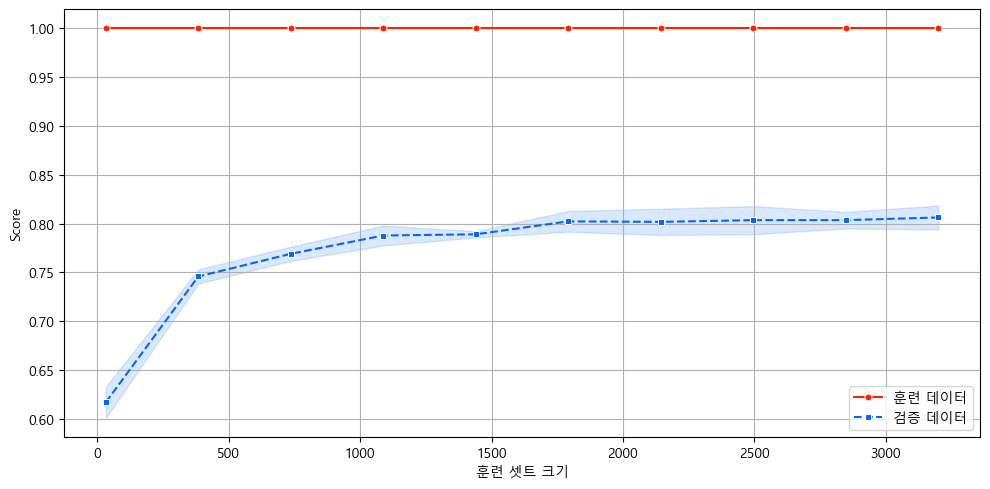

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7,
                     weights='distance')

In [23]:
my_knn_classification(x_train, y_train, x_test, y_test)

### [4] 로지스틱 분류구현

[교차검증]
+----+-------+------------+-----------+-------------------+
|    |     C |   max_iter | penalty   |   mean_test_score |
|----+-------+------------+-----------+-------------------|
| 13 |    10 |        500 | l2        |          0.752812 |
| 16 |   100 |        500 | l2        |          0.752812 |
|  7 |   0.1 |        500 | l2        |            0.7525 |
| 10 |     1 |        500 | l2        |            0.7525 |
|  4 |  0.01 |        500 | l2        |          0.749688 |
|  1 | 0.001 |        500 | l2        |          0.733438 |
+----+-------+------------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.267281 |  

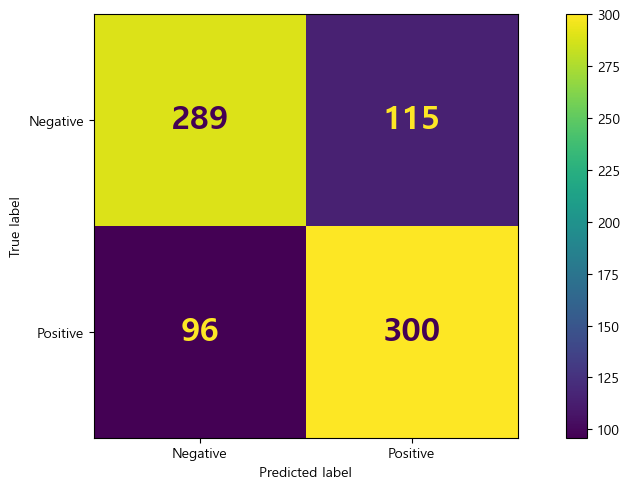

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


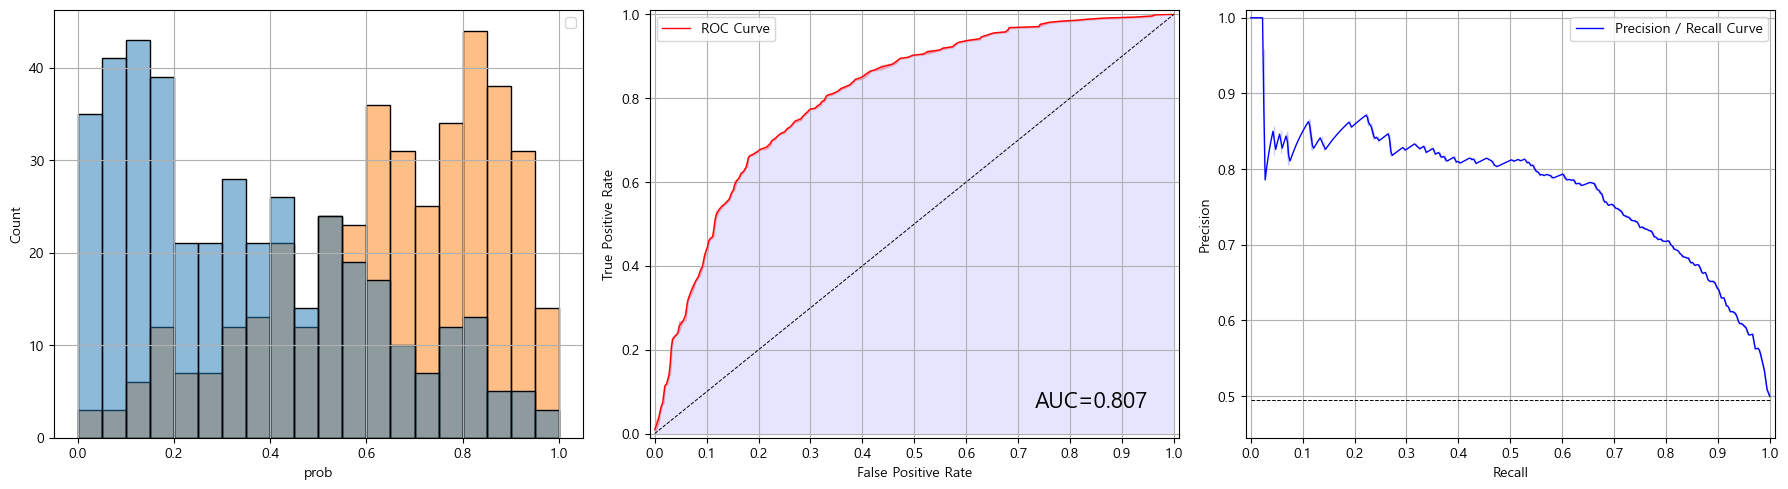


[학습곡선]


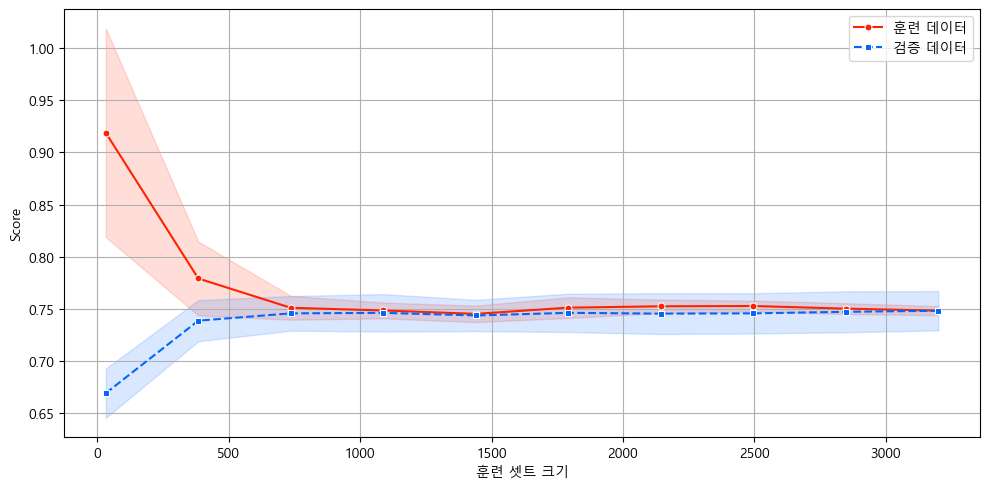

+----+------------+-------------+--------------------+------------+---------+------------+---------+------------+
|    | 종속변수   | 독립변수    |   B(비표준화 계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+------------+-------------+--------------------+------------+---------+------------+---------+------------|
|  0 | Quality    | Size        |             0.6589 |      0.064 | 10.2974 |          0 | 1.26265 |     1.9326 |
|  1 | Quality    | Weight      |             0.2633 |      0.067 |  3.9377 |          0 | 1.66448 |     1.3012 |
|  2 | Quality    | Sweetness   |             0.5951 |      0.062 |  9.5842 |          0 | 1.37202 |     1.8132 |
|  3 | Quality    | Crunchiness |             0.0283 |      0.068 |  0.4148 |      0.678 | 1.42554 |     1.0287 |
|  4 | Quality    | Juiciness   |             0.4348 |      0.055 |  7.9058 |          0 | 1.21852 |     1.5447 |
|  5 | Quality    | Ripeness    |            -0.1472 |      0.054 | -2.7027 |      0.007 | 1.57368 |     0.863

LogisticRegression(C=10, max_iter=500, n_jobs=-1)

In [32]:
my_logistic_classification(x_train, y_train, x_test, y_test)